In [1]:
import pandas as pd
import numpy as np

# Step 1: Load the four datasets
groceries_df = pd.read_csv("groceries_dataset.csv")
online_retail_df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')
winequality_df = pd.read_csv("winequality-red.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")

# Step 2: Modify the item_column and transaction_column for each dataset
groceries_item_column = 'itemDescription'
groceries_transaction_column = 'Member_number'

online_retail_item_column = 'StockCode'
online_retail_transaction_column = 'InvoiceNo'

winequality_df['transaction_id'] = winequality_df.index
winequality_item_column = 'quality'
winequality_transaction_column = 'transaction_id'

order_products_prior_item_column = 'product_id'
order_products_prior_transaction_column = 'order_id'

# Step 3: Determine the target number of unique items based on the minimum dataset
target_unique_items = min(
    groceries_df[groceries_item_column].nunique(),
    online_retail_df[online_retail_item_column].nunique(),
    winequality_df[winequality_item_column].nunique(),
    order_products_prior_df[order_products_prior_item_column].nunique()
)

# Step 4: Adjust unique items while keeping transaction counts the same
def adjust_unique_items_keep_transactions(df, item_column, transaction_column, target_unique_items):
    unique_items = df[item_column].unique()
    if len(unique_items) > target_unique_items:
        # 随机选择目标数量的唯一项目
        selected_items = np.random.choice(unique_items, target_unique_items, replace=False)
        # 仅保留选定的项目
        df = df[df[item_column].isin(selected_items)]
    return df

# Adjust unique items for each dataset without progress bar
datasets = [
    (groceries_df, groceries_item_column, groceries_transaction_column),
    (online_retail_df, online_retail_item_column, online_retail_transaction_column),
    (winequality_df, winequality_item_column, winequality_transaction_column),
    (order_products_prior_df, order_products_prior_item_column, order_products_prior_transaction_column)
]

for df, item_col, trans_col in datasets:
    df = adjust_unique_items_keep_transactions(df, item_col, trans_col, target_unique_items)

# Step 5: Preview the modified datasets
print("Groceries Dataset:")
print(groceries_df.head())
print("\nOnline Retail Dataset:")
print(online_retail_df.head())
print("\nWine Quality Dataset:")
print(winequality_df.head())
print("\nOrder Products Prior Dataset:")
print(order_products_prior_df.head())


Groceries Dataset:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Online Retail Dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:2

In [10]:
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import time


# Step 6: 运行 AR 挖掘程序并测量时间
def create_transaction_format(df, item_column, transaction_column):
    # 创建事务列表
    transactions = df.groupby(transaction_column)[item_column].apply(list).tolist()
    return transactions

# 创建每个数据集的事务格式
groceries_transactions = create_transaction_format(groceries_df, groceries_item_column, groceries_transaction_column)
online_retail_transactions = create_transaction_format(online_retail_df, online_retail_item_column, online_retail_transaction_column)
winequality_transactions = create_transaction_format(winequality_df, winequality_item_column, winequality_transaction_column)
order_products_transactions = create_transaction_format(order_products_prior_df, order_products_prior_item_column, order_products_prior_transaction_column)

# Step 7: 运行 AR 挖掘并测量时间
def run_ar_mining(transactions, min_support=0.05):
    # 随机选择部分交易
    sample_size = min(len(transactions), max(10, int(len(transactions) * 0.5)))  # 确保 sample_size 不超过事务总数
    sampled_transactions = random.sample(transactions, sample_size)

    # 使用 TransactionEncoder 处理事务
    encoder = TransactionEncoder()
    oht_df = encoder.fit(sampled_transactions).transform(sampled_transactions, sparse=True)
    oht_df = pd.DataFrame.sparse.from_spmatrix(oht_df, columns=encoder.columns_)

    # 将列名转换为字符串格式
    oht_df.columns = [str(col) for col in oht_df.columns]

    # 测量频繁项集生成的时间
    start_time = time.time()
    frequent_itemsets = apriori(oht_df, min_support=min_support, use_colnames=True)
    freq_time = time.time() - start_time

    # 检查生成的频繁项集
    print("Frequent Itemsets:")
    print(frequent_itemsets)

    # 测量高置信度规则生成的时间
    if not frequent_itemsets.empty:
        start_time = time.time()
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
        rules_time = time.time() - start_time
    else:
        rules_time = 0

    return freq_time, rules_time



# 如果 datasets 是一个列表，但你想将它变为字典
datasets = {
    f"Dataset_{i+1}": transactions for i, transactions in enumerate(datasets)
}

# 现在你可以使用 items() 方法
results = {}
for name, transactions in datasets.items():
    freq_time, rules_time = run_ar_mining(transactions, min_support=0.05)  # 根据需要调整支持度
    results[name] = {
        "Frequent Itemset Time": freq_time,
        "Rules Time": rules_time
    }

print(results)

    

Frequent Itemsets:
    support itemsets
0  0.111111      (G)
1  0.111111      (c)
2  0.222222      (e)
3  0.111111      (i)
4  0.111111      (o)
5  0.222222      (r)
6  0.111111      (s)
Frequent Itemsets:
   support itemsets
0      0.1      ( )
1      0.1      (R)
2      0.1      (a)
3      0.2      (e)
4      0.2      (i)
5      0.2      (l)
6      0.1      (n)
Frequent Itemsets:
   support itemsets
0      0.1      ( )
1      0.1      (Q)
2      0.1      (W)
3      0.1      (e)
4      0.2      (i)
5      0.1      (n)
6      0.1      (t)
7      0.1      (u)
8      0.1      (y)
Frequent Itemsets:
   support itemsets
0      0.1      ( )
1      0.1      (O)
2      0.1      (c)
3      0.1      (e)
4      0.1      (o)
5      0.3      (r)
6      0.1      (t)
7      0.1      (u)
{'Dataset_1': {'Frequent Itemset Time': 0.01634669303894043, 'Rules Time': 0.0008854866027832031}, 'Dataset_2': {'Frequent Itemset Time': 0.0020003318786621094, 'Rules Time': 0.0}, 'Dataset_3': {'Frequent Itemset Tim

In [11]:
# Step 8: 测量每个数据集的时间
datasets = {
    "Groceries": groceries_transactions,
    "Online Retail": online_retail_transactions,
    "Wine Quality": winequality_transactions,
    "Order Products": order_products_transactions
}

results = {}

for name, transactions in datasets.items():
    freq_time, rules_time = run_ar_mining(transactions, min_support=0.05)
    results[name] = {
        "Frequent Itemset Time": freq_time,
        "Rules Time": rules_time,
        "Total Time": freq_time + rules_time
    }

    # 打印结果
for dataset_name, times in results.items():
    print(f"Results for {dataset_name}:")
    print(f"Frequent Itemset Time: {times['Frequent Itemset Time']} seconds")
    print(f"Rules Time: {times['Rules Time']} seconds")
    print(f"Total Time: {times['Total Time']} seconds")
    print('-' * 40)

Frequent Itemsets:
      support                                itemsets
0    0.079015                              (UHT-milk)
1    0.109800                                  (beef)
2    0.073884                               (berries)
3    0.061057                             (beverages)
4    0.149307                          (bottled beer)
..        ...                                     ...
162  0.066701  (whole milk, yogurt, other vegetables)
163  0.051308       (rolls/buns, whole milk, sausage)
164  0.066701          (rolls/buns, whole milk, soda)
165  0.063622        (rolls/buns, whole milk, yogurt)
166  0.054387              (whole milk, yogurt, soda)

[167 rows x 2 columns]
Frequent Itemsets:
     support  itemsets
0   0.064402   (20725)
1   0.050888   (20727)
2   0.056062   (22197)
3   0.051351   (22383)
4   0.083475   (22423)
5   0.057143   (22720)
6   0.050965   (23203)
7   0.067336   (47566)
8   0.056371   (84879)
9   0.082934  (85099B)
10  0.089653  (85123A)
Frequent Items

In [16]:
# Step 9: 估算暴力方法的时间（根据需要进行调整）
def estimate_brute_force_time(num_transactions, num_items):
    # 示例估算（您可能希望使用更复杂的公式）
    return num_transactions * (num_items ** 2) * 0.001  # 占位值

brute_force_times = {name: estimate_brute_force_time(len(transactions), len(set(item for sublist in transactions for item in sublist)))
                     for name, transactions in datasets.items()}

In [19]:
import time

# 示例暴力破解算法，用于测量时间
def brute_force_algorithm(transactions):
    # 暂时假设暴力破解是对所有事务进行平方级别的计算
    start_time = time.time()
    # 暴力操作（这里仅作时间测试使用）
    for transaction in transactions:
        for item in transaction:
            pass  # 暂时没有具体操作，只是模拟计算过程
    end_time = time.time()
    return end_time - start_time  # 返回耗时

# Step 9: 估算暴力方法的时间
def estimate_brute_force_time(num_transactions, num_items, known_time, known_length):
    # 计算常数 C
    C = known_time / (known_length**2 + known_length)
    # 使用 C 估算任意事务数量的时间
    estimated_time = C * (num_transactions**2 + num_transactions)
    return estimated_time

# Step 1: 计算每个数据集的 known_time 和 known_length
known_values = {}
for name, transactions in datasets.items():
    # 测量暴力破解的处理时间
    known_time = brute_force_algorithm(transactions)
    # 获取事务集的长度
    known_length = len(transactions)
    
    # 存储每个数据集的 known_time 和 known_length
    known_values[name] = {
        "known_time": known_time,
        "known_length": known_length
    }

print("Each dataset's known_time and known_length:")
print(known_values)

# Step 2: 使用这些已知值计算暴力破解时间估算
brute_force_times = {
    name: estimate_brute_force_time(len(transactions), len(set(item for sublist in transactions for item in sublist)),
                                    known_values[name]['known_time'], known_values[name]['known_length'])
    for name, transactions in datasets.items()
}

print("Brute Force Times:")
print(brute_force_times)


Each dataset's known_time and known_length:
{'Groceries': {'known_time': 0.015625476837158203, 'known_length': 3898}, 'Online Retail': {'known_time': 0.046880245208740234, 'known_length': 25900}, 'Wine Quality': {'known_time': 0.0, 'known_length': 1599}, 'Order Products': {'known_time': 2.5080690383911133, 'known_length': 3214874}}
Brute Force Times:
{'Groceries': 0.015625476837158203, 'Online Retail': 0.046880245208740234, 'Wine Quality': 0.0, 'Order Products': 2.5080690383911133}


In [15]:
# Step 9: 估算暴力方法的时间（根据需要进行调整）
def estimate_brute_force_time(num_transactions, num_items, known_time, known_length):
    # 计算常数 C
    C = known_time / (known_length**2 + known_length)
    # 使用 C 估算任意事务数量的时间
    estimated_time = C * (num_transactions**2 + num_transactions)
    return estimated_time

# 使用已知值计算暴力破解时间估算
brute_force_times = {
    name: estimate_brute_force_time(
        len(transactions), 
        len(set(item for sublist in transactions for item in sublist)),
        known_values[name]['known_time'], 
        known_values[name]['known_length']
    )
    for name, transactions in datasets.items()
}

print("Brute Force Times:")
print(brute_force_times)



Brute Force Times:
{'Groceries': 0.0, 'Online Retail': 0.00599980354309082, 'Wine Quality': 0.0, 'Order Products': 0.46410417556762695}


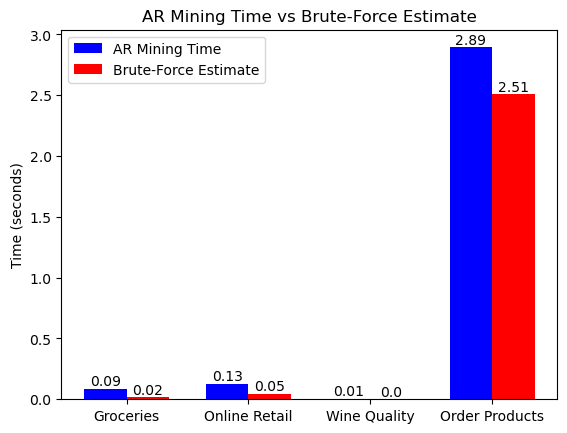

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Step 10: 绘制结果
labels = list(results.keys())
ar_times = [results[label]["Total Time"] for label in labels]
bf_times = [brute_force_times[label] for label in labels]

x = np.arange(len(labels))  # 标签位置
width = 0.35  # 条形宽度

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, ar_times, width, label='AR Mining Time', color='b')
bars2 = ax.bar(x + width/2, bf_times, width, label='Brute-Force Estimate', color='r')

# 添加标签、标题和自定义 x 轴刻度标签等
ax.set_ylabel('Time (seconds)')
ax.set_title('AR Mining Time vs Brute-Force Estimate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 在条形上方添加值标签
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

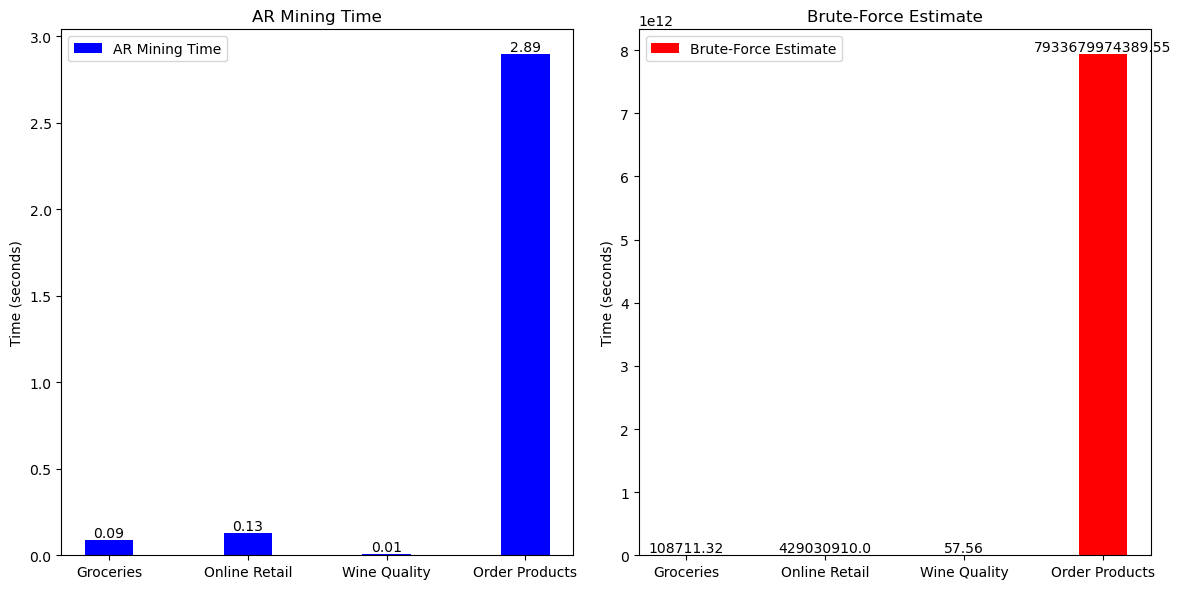

In [18]:

# Step 10: 绘制结果
labels = list(results.keys())
ar_times = [results[label]["Total Time"] for label in labels]
bf_times = [brute_force_times[label] for label in labels]

x = np.arange(len(labels))  # 标签位置
width = 0.35  # 条形宽度

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 绘制 AR Mining Time
bars1 = ax1.bar(x, ar_times, width, label='AR Mining Time', color='b')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('AR Mining Time')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# 在 AR Mining Time 的条形上方添加值标签
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# 绘制 Brute-Force Estimate
bars2 = ax2.bar(x, bf_times, width, label='Brute-Force Estimate', color='r')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Brute-Force Estimate')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

# 在 Brute-Force Estimate 的条形上方添加值标签
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()  # 自动调整子图参数
plt.show()
